# Importação de bibliotecas

In [1]:
import numpy as np # criação e manipulação de vetores
import matplotlib.pyplot as plt # graficos
import pandas as pd # read csv file
from scipy.optimize import minimize

# Formatação para gráficos

In [2]:
ft = 16
plt.rcParams.update({'font.size':ft})
ft2 = 20

# Leitura de base de dados

In [3]:
df = pd.read_excel('data.xlsx')

In [4]:
df

,T,k
0,300,6706
1,298,6698
2,330,6657
3,349,6880
4,364,6791
5,353,6917
6,370,7087
7,378,7043
8,373,7175
9,395,7236


A estimação de parâmetros envolve o ajuste de parâmetros em um modelo e refere-se a um problema de otimização. 

Em muitos casos, uma equação diferencial linear de primeira ordem pode aproximar a evolução de muitos sistemas. Os parâmetros desconhecidos para o sistema que iremos estudar como estudo de caso incluem o fator pré-exponencial ($A$) e a energia de ativação ($E_a$).

Nosso modelo:

$$
k(T) = A\cdot e^{-\frac{E_a}{RT}}
$$

In [5]:
R = 8.31451

O conjunto de dados em df corresponde a dados medidos experimentalmente.

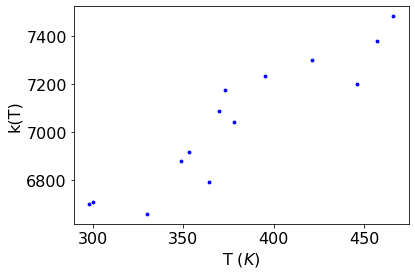

In [6]:
color1 = 'blue'
plt.xlabel('T ($K$)')
plt.ylabel('k(T)')
plt.scatter(df['T'],df['k'],c = color1,marker = 'o',s = 8)

plt.savefig('OriginalData.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

# Apresentação do problema a ser resolvido

Ajuste os dados a um sistema linear de primeira ordem estimando $E_a$ e $A$. Determine os intervalos de confiança de $95 \%$ e $99 \%$ para os parâmetros.

# Aplicação do método de otimização para a estimação de parâmetros...

Ver a seguinte referência:
- https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [7]:
modelo = lambda k1,k2,Temp: k1*np.exp(-k2/(R*Temp))

## Definição da função objetivo

In [8]:
def Fobj(par):
    dftemp = df.copy()
    dftemp['km'] = modelo(par[0],par[1],dftemp['T']) # km = k modelo
    dftemp['error'] = (dftemp['k'] - dftemp['km'])**2
    SSE = dftemp['error'].sum() # residual sum of squares
    return SSE

Uma vez que criamos nossa função objetivo, sem considerar os erros experimentais, estamos assumindo a hipótese de que os experimentos foram muito bem feitos e os erros experimentais podem ser desprezados. Como a nossa função objetivo é a métrica SSE, a chamamos de **função objetivo de mínimos quadrados**. 

Para mais informações sobre formulação de função objetivo, consulte as seguintes referências: 
- [Análise de Dados Experimentais 1: Fundamentos de Estatística e Estimação de Parâmetros, autores: Marcio Schwaab e José Carlos Pinto, editora: e-papers, 2007.](http://www.e-papers.com.br/produtos.asp?codigo_produto=2792)

- [wikipedia](https://pt.wikipedia.org/wiki/Método_dos_m%C3%ADnimos_quadrados)

- Escolhemos o método de otimização BFGS para estudo

In [9]:
x0 = [2000,1000]

In [10]:
res = minimize(Fobj, x0, method='BFGS',options={'disp': True})

         Current function value: 143607.435779
         Iterations: 18
         Function evaluations: 255
         Gradient evaluations: 82


- Parâmetros estimados:

In [11]:
res.x

array([9028.48898945,  770.5854663 ])

- adicionando uma nova coluna em df correspondente aos valores de *k* preditos pelo modelo com os parâmetros já estimados

In [12]:
df['km'] = modelo(res.x[0],res.x[1],df['T'])

In [13]:
df.head()

,T,k,km
0,300,6706,6628.993741
1,298,6698,6615.263628
2,330,6657,6817.806186
3,349,6880,6922.849250
4,364,6791,6999.024160


In [22]:
df.describe()

,T,k,km
count,14.000000,14.000000,14.000000
mean,378.571429,7039.571429,7039.554961
std,53.551865,269.268729,248.406674
min,298.000000,6657.000000,6615.263628
25%,350.000000,6813.250000,6928.065069
50%,371.500000,7065.000000,7035.068555
75%,414.500000,7227.000000,7218.451861
max,466.000000,7484.000000,7400.161009


In [23]:
269.26**2 

72500.9476

# Métricas de regressão

## SSE: 

- Error sum of squares
- Soma dos erros ao quadrado

$$
SSE = \sum_{i=1}^{N} (y_{original} - y_{predito})^2
$$

In [14]:
SSE = res.fun
SSE

143607.43577866183

## MSE:

- Mean squared error
- Erro quadrático médio

$$
MSE = \frac{1}{N}\sum_{i=1}^{N} (y_{original} - y_{predito})^2
$$

In [15]:
N = df['T'].index[-1]+1
N 

14

In [16]:
MSE = SSE/N
MSE

10257.67398419013

## RMSE:

- Root-mean-square deviation
- Raiz do erro quadrático médio

$$
RMSE = \sqrt{MSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (y_{original} - y_{predito})^2}
$$

In [17]:
RMSE = MSE**0.5
RMSE

101.28017567219229

## $R^2$

- Coefficient of determination
- Coeficiente de determinação

$$
R^2 = 1 - \frac{SSE}{\sum_{i=1}^{N}(y_{original} - y_{média})^2}
$$

In [18]:
from sklearn.metrics import r2_score

In [19]:
R2 = r2_score(df['k'],df['km'])
R2

0.8476432377302272

In [20]:
result = pd.DataFrame({'SSE':[res.fun],
             'MSE':[MSE],
              'RMSE':[RMSE],
              'R2':[R2],
             'A':[res.x[0]],
             'Ea':[res.x[1]],
             '$N_{it}$':[res.nit],
             '$N_{fun_{eval}}$':[res.nfev]},
             index = ['BFGS']).T

In [21]:
result

,BFGS
SSE,143607.435779
MSE,10257.673984
RMSE,101.280176
R2,0.847643
A,9028.488989
Ea,770.585466
$N_{it}$,18.000000
$N_{fun_{eval}}$,255.000000


# Visualização gráfica dos resultados

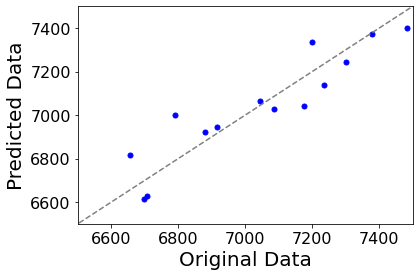

In [24]:
color1 = 'blue'
plt.xlabel('Original Data',fontsize = ft2)
plt.ylabel('Predicted Data',fontsize = ft2)
plt.scatter(df['k'],df['km'],c = color1,marker = 'o',s = 25)
color2 = 'grey'
plt.plot([6000,8000],[6000,8000],c=color2,linestyle='--')
plt.xlim([6500,7500])
plt.ylim([6500,7500])
plt.savefig('finalplot.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

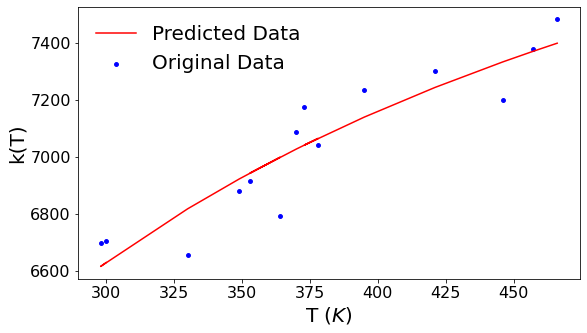

In [25]:
plt.figure(figsize=(9,5))
color1 = 'blue'
plt.xlabel('T ($K$)',fontsize = ft2)
plt.ylabel('k(T)',fontsize = ft2)
plt.scatter(df['T'],df['k'],c = color1,marker = 'o',s = 15,label = 'Original Data')
color2 = 'red'
plt.plot(df['T'],df['km'],c=color2, label = 'Predicted Data')
plt.legend(frameon = False,fontsize = ft2)
plt.savefig('finalplot2.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

# Atividade

- Refazer esse notebook, porém aplicando outro método de otimização da sua escolha.